<a href="https://colab.research.google.com/github/Guliko24/NetZoo_network/blob/main/MCF7_MDA_final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **I will recreate the graphs from  GRN_13_Laplacian_matrxix_with_PyGSP_v4 file with RNAseq data from GSE73857.**



In [1]:
#import all the packages as needed
import pandas as pd
import networkx as nx

In [2]:
# prompt: let's load Gdrive onto notebook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



*** We  be saving all our output files in the new folder GSE73857_MCF7_MDA_MB231_final_files


In [3]:
# Navigate to your Google Drive files
%cd /content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/GSE73857_MCF7_MDA_MB231_final_files

/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/GSE73857_MCF7_MDA_MB231_final_files


# **1. Let's load the TF-gene matrices (from GRAND database) for MCF7 and MDA cells**

In [4]:
#let's read the MCF7_TF_Genes dataset and make changes
df_MCF7_TF_Genes = pd.read_csv('/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/ACH-000019_TF_vs_Genes_total expression.csv', index_col=0)
df_MDA_MB231_TF_Genes=pd.read_csv('/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/ACH-000768.csv', index_col=0)


In [5]:
import numpy as np
import pandas as pd

def normalize_matrix(matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize the values in the matrix to a range of [0, 1].
    """
    normalized_matrix = (matrix - matrix.min().min()) / (matrix.max().max() - matrix.min().min())
    return normalized_matrix

def filter_by_threshold(matrix: pd.DataFrame, threshold: float, mode: str = 'greater') -> pd.DataFrame:
    """
    Filter the matrix based on a threshold.
    Parameters:
        matrix: The TF vs Genes interaction matrix.
        threshold: The threshold value for filtering.
        mode: 'greater' to keep values greater than threshold, 'less' to keep values less than threshold.
    """
    if mode == 'greater':
        return matrix[matrix > threshold].fillna(0)
    elif mode == 'less':
        return matrix[matrix < threshold].fillna(0)
    else:
        raise ValueError("Mode must be either 'greater' or 'less'")

def binarize_matrix(matrix: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    Binarize the matrix based on a threshold.
    Values greater than or equal to the threshold become 1, otherwise 0.
    """
    binary_matrix = (matrix >= threshold).astype(int)
    return binary_matrix

def rank_interactions(matrix: pd.DataFrame, top_n: int = 5) -> pd.DataFrame:
    """
    Rank the top N interactions for each transcription factor.
    Parameters:
        matrix: The TF vs Genes interaction matrix.
        top_n: Number of top interactions to return for each TF.
    """
    ranked_interactions = pd.DataFrame()
    for tf in matrix.index:
        top_genes = matrix.loc[tf].nlargest(top_n)
        ranked_interactions = pd.concat([ranked_interactions, top_genes], axis=1)
    return ranked_interactions.T

def aggregate_interactions(matrix: pd.DataFrame, axis: int = 0) -> pd.Series:
    """
    Aggregate interaction strengths.
    Parameters:
        axis: 0 to aggregate across genes (per TF), 1 to aggregate across TFs (per Gene).
    """
    return matrix.sum(axis=axis)

def construct_interaction_network(matrix: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    Construct an interaction network by keeping only interactions above a threshold.
    Returns a DataFrame representing edges in the network.
    """
    filtered_matrix = filter_by_threshold(matrix, threshold, mode='greater')
    edges = []
    for tf in filtered_matrix.index:
        for gene in filtered_matrix.columns:
            if filtered_matrix.loc[tf, gene] > 0:
                edges.append((tf, gene, filtered_matrix.loc[tf, gene]))
    network_df = pd.DataFrame(edges, columns=['TF', 'Gene', 'Interaction_Strength'])
    return network_df

def split_positive_negative_matrices(matrix: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    Split the matrix into two DataFrames: one for positive values and one for negative values.
    Ensure that the matrix values are numeric by coercing errors and replacing non-numeric values with NaN.
    Retain the index and columns in both matrices.
    """
    matrix_numeric = matrix.apply(pd.to_numeric, errors='coerce')
    positive_matrix = matrix_numeric.where(matrix_numeric > 0).fillna(0)
    negative_matrix = matrix_numeric.where(matrix_numeric < 0).fillna(0)
    positive_matrix.index = matrix.index
    positive_matrix.columns = matrix.columns
    negative_matrix.index = matrix.index
    negative_matrix.columns = matrix.columns
    return positive_matrix, negative_matrix

def check_repeated_indices_columns(matrix: pd.DataFrame):
    """
    Check for repeated transcription factors (rows) and genes (columns) in the matrix.
    """
    repeated_rows = matrix.index[matrix.index.duplicated()].unique()
    repeated_columns = matrix.columns[matrix.columns.duplicated()].unique()

    print("Repeated Rows (TFs):")
    if len(repeated_rows) > 0:
        print(repeated_rows)
    else:
        print("No repeated rows found.")

    print("\nRepeated Columns (Genes):")
    if len(repeated_columns) > 0:
        print(repeated_columns)
    else:
        print("No repeated columns found.")



In [6]:
# Example Usage
# Read the TF vs Genes matrix from a CSV file
#df_MCF7_TF_Genes = pd.read_csv('/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/ACH-000019_TF_vs_Genes_total expression.csv', index_col=0)

# Normalize the matrix
#normalized_df = normalize_matrix(df_MCF7_TF_Genes)

# Filter interactions greater than 0.5
#filtered_df = filter_by_threshold(df_MCF7_TF_Genes, threshold=0.5, mode='greater')

# Binarize the matrix with a threshold of 0.5
#binary_df = binarize_matrix(df_MCF7_TF_Genes, threshold=0.5)

# Rank top 2 interactions for each TF
#ranked_df = rank_interactions(df_MCF7_TF_Genes, top_n=2)

# Aggregate interactions across genes (per TF)
#aggregated_series = aggregate_interactions(df_MCF7_TF_Genes, axis=1)

# Construct interaction network with a threshold of 0.5
#network_df = construct_interaction_network(df_MCF7_TF_Genes, threshold=0.5)

# Split the matrix into positive and negative interaction matrices
#positive_df, negative_df = split_positive_negative_matrices(df_MCF7_TF_Genes)

# **2. Lets split matrices into positive and negative matrices based on the edge weights**

In [7]:
#split MCF7 matrix into pos and neg
MCF7_positive_df, MCF7_negative_df = split_positive_negative_matrices(df_MCF7_TF_Genes)
MCF7_positive_df.head()
MCF7_negative_df.head()

A1BG      A1CF       A2M     A2ML1   A3GALT2    A4GALT     A4GNT  \
Row                                                                          
AHR  -1.443279 -1.967447 -2.760445 -2.073087  0.000000  0.000000 -1.715180   
AHRR -1.247997 -2.028449 -2.831273 -1.976606  0.000000  0.000000 -1.723908   
AIRE -1.380017  0.000000  0.000000  0.000000 -3.535072 -1.611140  0.000000   
ALX1 -2.001329  0.000000 -0.656243  0.000000  0.000000 -0.584100  0.000000   
ALX3 -1.201413  0.000000 -0.211441  0.000000 -0.089130 -0.913549  0.000000   

          AAAS      AACS     AADAC  ...    TMEM88   TMEM88B    TMEM89  \
Row                                 ...                                 
AHR   0.000000  0.000000 -1.152120  ... -0.878857  0.000000  0.000000   
AHRR  0.000000  0.000000 -1.189913  ... -0.761727  0.000000  0.000000   
AIRE -1.797554 -1.676323 -1.153214  ... -1.082261 -1.291455 -1.956019   
ALX1  0.000000 -1.492440  0.000000  ... -1.472459 -1.322024 -0.123587   
ALX3  0.000000 -1.522372  0.000000  ... -2.399966 -1.392676  0.000000   

        TMEM8B     TMEM9    TMEM91    TMEM92    TMEM94    TMEM95    TMEM97  
Row                                                                         
AHR  -1.016009 -0.242322  0.000000 -0.818321 -0.052743 -0.473725 -0.298555  
AHRR -0.775855 -0.152985  0.000000 -0.680559  0.000000 -0.332161 -0.117967  
AIRE -0.419732 -0.210442 -1.207542 -0.703877 -1.442472 -0.474597 -0.882657  
ALX1 -2.152722 -2.204323 -0.050309 -2.532883 -0.852312 -2.007539 -1.760582  
ALX3 -2.412815 -2.458452  0.000000 -2.533361 -1.395355 -2.138298 -2.579043  

[5 rows x 16383 columns]

In [8]:
#split MDA_Mb231 matrix into pos and neg
MDA_positive_df, MDA_negative_df = split_positive_negative_matrices(df_MDA_MB231_TF_Genes)
MDA_positive_df.head()
MDA_negative_df.head()

A1BG      A1CF       A2M     A2ML1  A3GALT2    A4GALT     A4GNT  \
Row                                                                         
AHR  -1.448563 -2.284170 -2.048069 -2.264498      0.0 -0.053591 -1.633524   
AHRR -1.264257 -2.349954 -2.185647 -2.152969      0.0  0.000000 -1.662965   
AIRE -1.123451  0.000000 -0.467839  0.000000      0.0 -0.659312  0.000000   
ALX1 -1.858799  0.000000  0.000000  0.000000      0.0 -1.088905  0.000000   
ALX3 -0.962345  0.000000  0.000000  0.000000      0.0 -1.132987  0.000000   

          AAAS      AACS     AADAC  ...    ZWILCH     ZWINT      ZXDA  \
Row                                 ...                                 
AHR  -1.166887 -1.177184 -2.545726  ... -0.395061 -2.423942 -1.526902   
AHRR -0.980370 -0.921086 -2.435069  ... -0.503005 -2.400454 -1.657514   
AIRE -0.960508 -1.848828 -1.694674  ...  0.000000 -0.303865  0.000000   
ALX1 -2.183060 -2.379275 -0.286095  ...  0.000000 -0.155270  0.000000   
ALX3 -2.977034 -2.616413 -1.650841  ...  0.000000 -1.329236  0.000000   

          ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX     ZZEF1      ZZZ3  
Row                                                                         
AHR  -2.267134  0.000000 -2.928558 -0.280536 -1.684660  0.000000  0.000000  
AHRR -2.273704  0.000000 -2.838389 -0.188903 -1.445998  0.000000  0.000000  
AIRE -0.356376 -2.208080  0.000000 -0.582978 -1.890069 -1.811252 -1.039348  
ALX1 -0.544151 -1.888662 -0.163275 -0.685296 -2.875321 -2.705523 -0.346683  
ALX3  0.000000 -1.843481 -1.387364 -0.975086 -3.358992 -2.483430 -0.183521  

[5 rows x 18560 columns]

In [9]:
#lets check whether there is a repetition of rows or columns
# Check for repeated rows (TFs) and columns (Genes)
check_repeated_indices_columns(MCF7_positive_df)
check_repeated_indices_columns(MCF7_negative_df)
check_repeated_indices_columns(MDA_positive_df)
check_repeated_indices_columns(MDA_negative_df)

Repeated Rows (TFs):
No repeated rows found.

Repeated Columns (Genes):
No repeated columns found.
Repeated Rows (TFs):
No repeated rows found.

Repeated Columns (Genes):
No repeated columns found.
Repeated Rows (TFs):
No repeated rows found.

Repeated Columns (Genes):
No repeated columns found.
Repeated Rows (TFs):
No repeated rows found.

Repeated Columns (Genes):
No repeated columns found.


# 3. Select 300 strongest postive interactions from a positive matrix and 300 most negative interactions from a negative matrix

In [10]:
# Flatten the dataframe into a series with TF-Gene pair as the index
ranked_MCF7_positive_df = MCF7_positive_df.stack().sort_values(ascending=False)

# Get the top 300 interactions
top_300_MCF7_positive_df = ranked_MCF7_positive_df.head(300)
print(top_300_MCF7_positive_df)


Row          
IRX6    MEOX2    64.130060
IRX4    MEOX2    63.920394
IRX6    FIGN     60.464314
IRX4    FIGN     60.087284
ZHX1    FIGN     57.886189
                   ...    
HSF5    FIGN     27.082079
HOXD11  MEOX2    27.081816
DMBX1   FIGN     27.066984
RREB1   MAP9     27.058980
RUNX2   SCN1A    27.034722
Length: 300, dtype: float64


In [11]:
# Flatten the dataframe into a series with TF-Gene pair as the index
ranked_MCF7_negative_df = MCF7_negative_df.stack().sort_values(ascending=True)

# Get the top 300 interactions
top_300_MCF7_negative_df = ranked_MCF7_negative_df.head(300)
print(top_300_MCF7_negative_df)


Row           
ZNF287  FIGN     -101.616735
ZNF432  FIGN      -89.941910
ZNF287  MEOX2     -87.128990
ZNF235  FIGN      -85.876623
ZNF880  FIGN      -85.234935
                     ...    
ZNF548  RAB40A    -32.135950
ZNF774  S1PR1     -32.071424
ZNF398  PODN      -32.057540
ZNF774  MYBPH     -31.898493
ZNF880  MYBPH     -31.883776
Length: 300, dtype: float64


In [12]:
# Flatten the dataframe into a series with TF-Gene pair as the index
ranked_MDA_positive_df = MDA_positive_df.stack().sort_values(ascending=False)

# Get the top 300 interactions
top_300_MDA_positive_df = ranked_MDA_positive_df.head(300)
print(top_300_MDA_positive_df)
# Flatten the dataframe into a series with TF-Gene pair as the index
ranked_MDA_negative_df = MDA_negative_df.stack().sort_values(ascending=True)

# Get the top 300 interactions
top_300_MDA_negative_df = ranked_MDA_negative_df.head(300)
print(top_300_MDA_negative_df)

Row            
IRX6     SRFBP1    85.692635
IRX4     SRFBP1    83.858578
OVOL1    SRFBP1    51.255897
HOXA10   SRFBP1    51.053823
HOXD9    SRFBP1    49.335667
                     ...    
ZNF341   KAT6B     30.285569
CUX2     SRFBP1    30.285557
FOSB     SRFBP1    30.268770
CREB3    SRFBP1    30.227419
BHLHA15  ATXN3L    30.222472
Length: 300, dtype: float64
Row           
ZNF180  SRFBP1   -160.193597
ZBTB7B  SRFBP1   -132.743975
ZNF880  SRFBP1   -131.859299
ZNF287  SRFBP1   -130.285270
ZNF432  SRFBP1   -124.492368
                     ...    
ZNF611  FUNDC1    -33.616524
SP6     USP14     -33.526840
ZNF506  SRFBP1    -33.392813
SP7     USP14     -33.392643
NHLH1   SRFBP1    -33.337106
Length: 300, dtype: float64


lets rename the column names into Source, Target, Edge weight


In [13]:
def rename_columns(df, column_names):
    """
    Reset the index and rename columns of a dataframe or pandas Series.

    Parameters:
        df (pd.DataFrame or pd.Series): The dataframe or series to process.
        column_names (list): List of new column names.

    Returns:
        pd.DataFrame: Dataframe with reset index and renamed columns.
    """
    if isinstance(df, pd.Series):
        df = df.to_frame()

    df = df.reset_index()

    if len(df.columns) != len(column_names):
        raise ValueError("The number of new column names must match the number of columns in the dataframe.")

    df.columns = column_names
    return df

# Example usage:
# renamed_df = rename_columns(some_series_or_df, ["Source", "Target", "Edge weight"])


In [14]:
top_300_MCF7_negative_df=rename_columns(top_300_MCF7_negative_df, ["Source", "Target", "Edge weight"])
top_300_MCF7_positive_df=rename_columns(top_300_MCF7_positive_df, ["Source", "Target", "Edge weight"])
top_300_MDA_negative_df=rename_columns(top_300_MDA_negative_df, ["Source", "Target", "Edge weight"])
top_300_MDA_positive_df=rename_columns(top_300_MDA_positive_df, ["Source", "Target", "Edge weight"])


# **4. Build graphs with NetworkX**

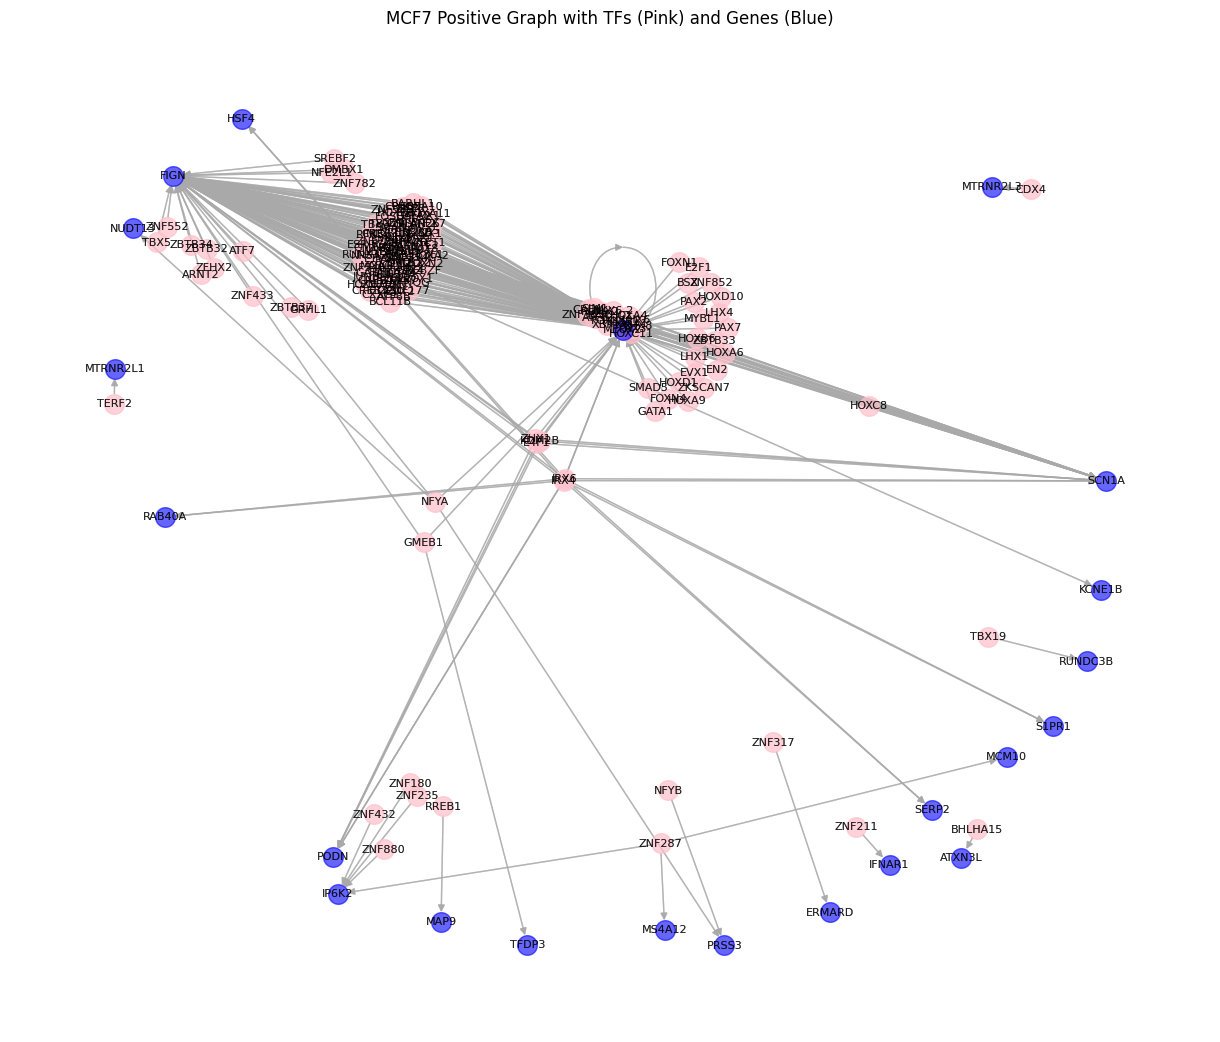

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from networkx.algorithms import community



# Initialize directed graph for positive interactions
G_positive_MCF7= nx.DiGraph()

# Add edges from the dataframe to the directed graph
for _, row in top_300_MCF7_positive_df.iterrows():
    G_positive_MCF7.add_edge(row['Source'], row['Target'], weight=row['Edge weight'])

# Set a layout for the graph
pos = nx.spring_layout(G_positive_MCF7, k=0.8, iterations=100)

# Separate nodes based on Source and Target
source_nodes = set(top_300_MCF7_positive_df['Source'])
target_nodes = set(top_300_MCF7_positive_df['Target'])

# Draw the main graph
plt.figure(figsize=(12, 10))
nx.draw(
    G_positive_MCF7, pos, with_labels=True, node_size=200, nodelist=source_nodes,
    node_color="pink", alpha=0.7, font_size=8, edge_color="darkgrey"
)
nx.draw(
    G_positive_MCF7, pos, with_labels=True, node_size=200, nodelist=target_nodes,
    node_color="blue", alpha=0.6, font_size=8, edge_color="darkgrey"
)
plt.title("MCF7 Positive Graph with TFs (Pink) and Genes (Blue)")
plt.show()

# Calculate communities
communities = community.greedy_modularity_communities(G_positive_MCF7)
# Create subplots for communities
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for idx, comm in enumerate(communities[:2]):  # First two communities
    subgraph = G_positive_MCF7.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, k=0.8)  # Separate layout for each community

    # Separate nodes into TFs and genes for this subgraph
    sub_source_nodes = [node for node in comm if node in source_nodes]
    sub_target_nodes = [node for node in comm if node in target_nodes]

    # Draw source nodes (TFs) in pink
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=200,
        nodelist=sub_source_nodes, node_color="pink", alpha=0.7, font_size=8
    )

    # Draw target nodes (genes) in blue
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=200,
        nodelist=sub_target_nodes, node_color="blue", alpha=0.6, font_size=8
    )

    axes[idx].set_title(f"Community {idx + 1}")

plt.tight_layout()
plt.show()


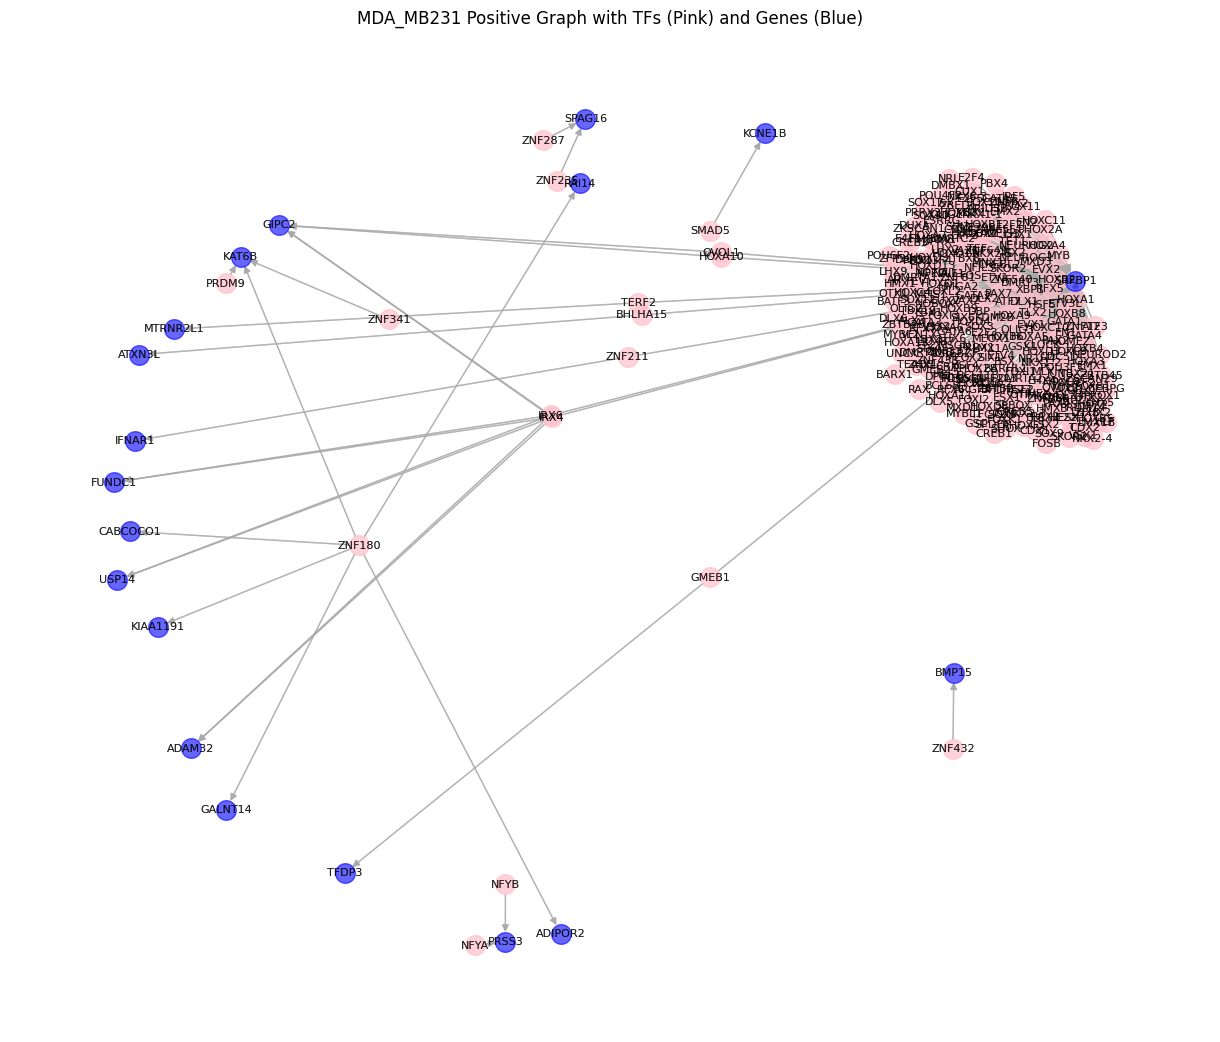

In [16]:



# Initialize directed graph for positive interactions
G_positive_MDA = nx.DiGraph()

# Add edges from the dataframe to the directed graph
for _, row in top_300_MDA_positive_df.iterrows():
    G_positive_MDA.add_edge(row['Source'], row['Target'], weight=row['Edge weight'])

# Set a layout for the graph
pos = nx.spring_layout(G_positive_MDA, k=0.8, iterations=100)

# Separate nodes based on Source and Target
source_nodes = set(top_300_MDA_positive_df['Source'])
target_nodes = set(top_300_MDA_positive_df['Target'])

# Draw the main graph
plt.figure(figsize=(12, 10))
nx.draw(
    G_positive_MDA, pos, with_labels=True, node_size=200, nodelist=source_nodes,
    node_color="pink", alpha=0.7, font_size=8, edge_color="darkgrey"
)
nx.draw(
    G_positive_MDA, pos, with_labels=True, node_size=200, nodelist=target_nodes,
    node_color="blue", alpha=0.6, font_size=8, edge_color="darkgrey"
)
plt.title("MDA_MB231 Positive Graph with TFs (Pink) and Genes (Blue)")
plt.show()

# Calculate communities
communities = community.greedy_modularity_communities(G_positive_MDA)
# Create subplots for communities
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for idx, comm in enumerate(communities[:2]):  # First two communities
    subgraph = G_positive_MDA.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, k=0.8)  # Separate layout for each community

    # Separate nodes into TFs and genes for this subgraph
    sub_source_nodes = [node for node in comm if node in source_nodes]
    sub_target_nodes = [node for node in comm if node in target_nodes]

    # Draw source nodes (TFs) in pink
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=200,
        nodelist=sub_source_nodes, node_color="pink", alpha=0.7, font_size=8
    )

    # Draw target nodes (genes) in blue
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=200,
        nodelist=sub_target_nodes, node_color="blue", alpha=0.6, font_size=8
    )

    axes[idx].set_title(f"Community {idx + 1}")

plt.tight_layout()
plt.show()


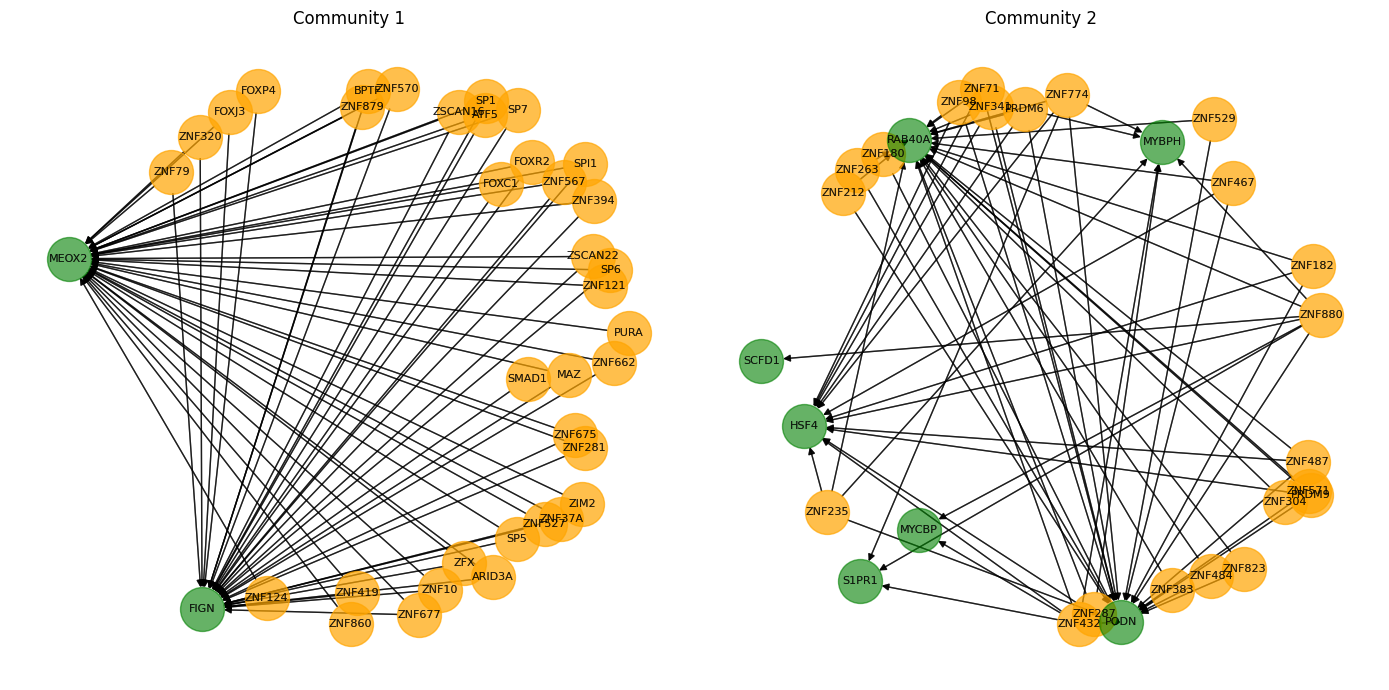

In [18]:

# Initialize directed graph for negative interactions
G_negative_MCF7 = nx.DiGraph()

# Add edges from the dataframe to the directed graph
for _, row in top_300_MCF7_negative_df.iterrows():
    G_negative_MCF7.add_edge(row['Source'], row['Target'], weight=row['Edge weight'])

# Set a layout for the graph
pos = nx.spring_layout(G_negative_MCF7, k=0.6, iterations=30)

# Separate nodes based on Source and Target
source_nodes = set(top_300_MCF7_negative_df['Source'])
target_nodes = set(top_300_MCF7_negative_df['Target'])

# Draw the main graph
plt.figure(figsize=(10, 8))
nx.draw(
    G_negative_MCF7, pos, with_labels=True, node_size=1000, nodelist=source_nodes,
    node_color="orange", alpha=0.7, font_size=8, edge_color="darkgrey"
)
nx.draw(
    G_negative_MCF7, pos, with_labels=True, node_size=1000, nodelist=target_nodes,
    node_color="green", alpha=0.6, font_size=8, edge_color="darkgrey"
)
plt.title("MCF7 Negative Graph with TFs (Orange) and Genes (Green)")
plt.show()

# Calculate communities for the negative graph
communities_negative = community.greedy_modularity_communities(G_negative_MCF7)

# Create subplots for communities
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for idx, comm in enumerate(communities_negative[:2]):  # First two communities
    subgraph = G_negative_MCF7.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, k=0.8)  # Separate layout for each community

    # Separate nodes into TFs and genes for this subgraph
    sub_source_nodes = [node for node in comm if node in source_nodes]
    sub_target_nodes = [node for node in comm if node in target_nodes]

    # Draw source nodes (TFs) in orange
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=1000,
        nodelist=sub_source_nodes, node_color="orange", alpha=0.7, font_size=8
    )

    # Draw target nodes (genes) in green
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=1000,
        nodelist=sub_target_nodes, node_color="green", alpha=0.6, font_size=8
    )

    axes[idx].set_title(f"Community {idx + 1}")

plt.tight_layout()
plt.show()


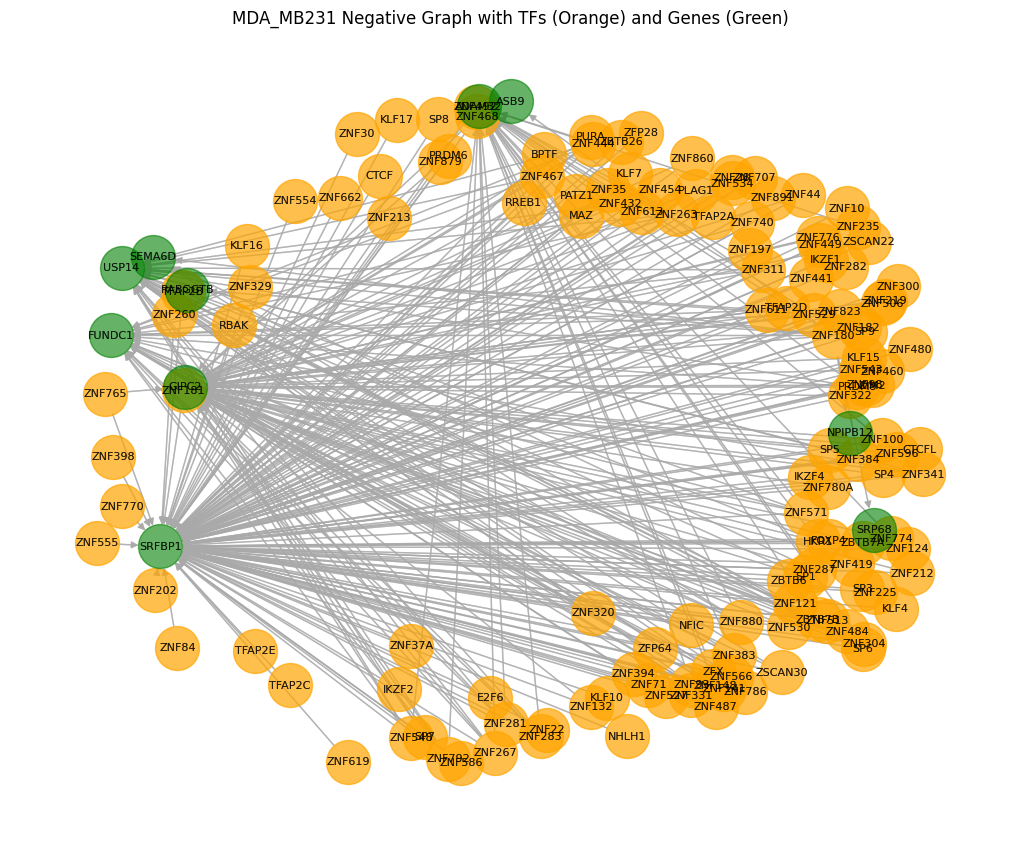

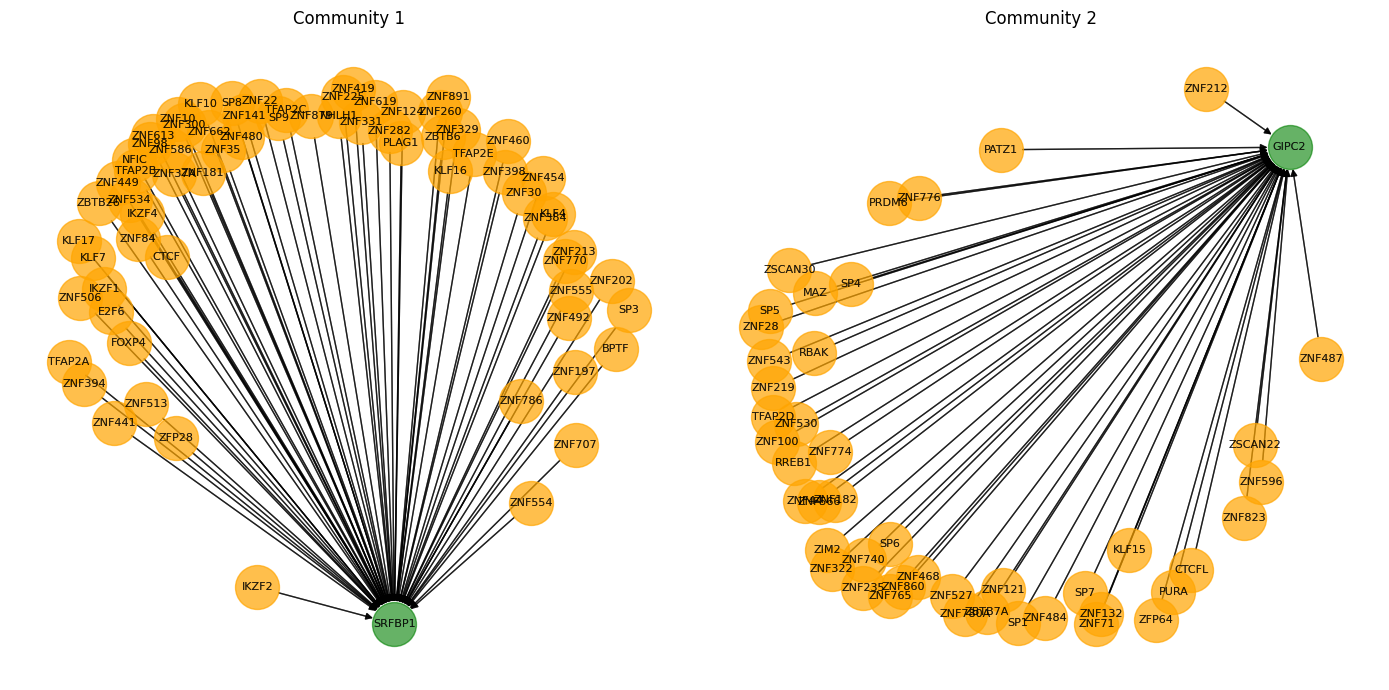

In [19]:

# Initialize directed graph for negative interactions
G_negative_MDA = nx.DiGraph()

# Add edges from the dataframe to the directed graph
for _, row in top_300_MDA_negative_df.iterrows():
    G_negative_MDA.add_edge(row['Source'], row['Target'], weight=row['Edge weight'])

# Set a layout for the graph
pos = nx.spring_layout(G_negative_MDA, k=0.6, iterations=30)

# Separate nodes based on Source and Target
source_nodes = set(top_300_MDA_negative_df['Source'])
target_nodes = set(top_300_MDA_negative_df['Target'])

# Draw the main graph
plt.figure(figsize=(10, 8))
nx.draw(
    G_negative_MDA, pos, with_labels=True, node_size=1000, nodelist=source_nodes,
    node_color="orange", alpha=0.7, font_size=8, edge_color="darkgrey"
)
nx.draw(
    G_negative_MDA, pos, with_labels=True, node_size=1000, nodelist=target_nodes,
    node_color="green", alpha=0.6, font_size=8, edge_color="darkgrey"
)
plt.title("MDA_MB231 Negative Graph with TFs (Orange) and Genes (Green)")
plt.show()

# Calculate communities for the negative graph
communities_negative = community.greedy_modularity_communities(G_negative_MDA)

# Create subplots for communities
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for idx, comm in enumerate(communities_negative[:2]):  # First two communities
    subgraph = G_negative_MDA.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, k=0.8)  # Separate layout for each community

    # Separate nodes into TFs and genes for this subgraph
    sub_source_nodes = [node for node in comm if node in source_nodes]
    sub_target_nodes = [node for node in comm if node in target_nodes]

    # Draw source nodes (TFs) in orange
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=1000,
        nodelist=sub_source_nodes, node_color="orange", alpha=0.7, font_size=8
    )

    # Draw target nodes (genes) in green
    nx.draw(
        subgraph, sub_pos, ax=axes[idx], with_labels=True, node_size=1000,
        nodelist=sub_target_nodes, node_color="green", alpha=0.6, font_size=8
    )

    axes[idx].set_title(f"Community {idx + 1}")

plt.tight_layout()
plt.show()


# Save graphs for further usage

In [20]:
#Save the graph in formats like GraphML or GEXF for visualization in tools like Gephi.
nx.write_graphml(G_positive_MCF7, "positive_MCF7_interactions.graphml")
nx.write_graphml(G_negative_MCF7, "negative_MCF7_interactions.graphml")
nx.write_graphml(G_positive_MDA, "positive_MDA_interactions.graphml")
nx.write_graphml(G_negative_MDA, "negative_MDA_interactions.graphml")

# **# Let's install PyGPS (suggested by Ortega) and use it for signal processing**:

In [21]:
pip install pygsp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00


# **1. Convert NetworkX Graph to PyGSP Graph**

# Lets construct PyGSP positive graph from G_positive_MCF7

In [22]:
#I decided to use PyGSP package so few adjustments will be required
import networkx as nx
import pygsp as pg
from networkx import to_scipy_sparse_array


# Extract adjacency matrix from NetworkX graph as a sparse array
G_positive_MCF7.remove_edges_from(nx.selfloop_edges(G_positive_MCF7))##### remove the loop here so now I have 299 edges
adjacency_matrix_MCF7_pos = to_scipy_sparse_array(G_positive_MCF7, weight=" Edge weight")

# Create PyGSP graph
gsp_graph_MCF7_pos= pg.graphs.Graph(adjacency_matrix_MCF7_pos)

# Display basic graph info
print(f"PyGSP Graph Positive with {gsp_graph_MCF7_pos.N} nodes and {gsp_graph_MCF7_pos.Ne} edges.")


PyGSP Graph Positive with 174 nodes and 299 edges.


# Lets construct PyGSP positive graph from G_positive_MDA

In [23]:

# Extract adjacency matrix from NetworkX graph as a sparse array
G_positive_MDA.remove_edges_from(nx.selfloop_edges(G_positive_MDA))##### remove the loop here so now I have 299 edges
adjacency_matrix_MDA_pos = to_scipy_sparse_array(G_positive_MDA, weight=" Edge weight")

# Create PyGSP graph
gsp_graph_MDA_pos= pg.graphs.Graph(adjacency_matrix_MDA_pos)

# Display basic graph info
print(f"PyGSP Graph Positive with {gsp_graph_MDA_pos.N} nodes and {gsp_graph_MDA_pos.Ne} edges.")


PyGSP Graph Positive with 300 nodes and 300 edges.


# Lets construct PyGSP negative graph from G_negative_MCF7

In [24]:
# Extract adjacency matrix from NetworkX graph for Negative graph
# Extract adjacency matrix from NetworkX graph as a sparse array
adjacency_matrix_MCF7_neg = to_scipy_sparse_array(G_negative_MCF7, weight=" Edge weight")

# Create PyGSP graph
gsp_graph_MCF7_neg= pg.graphs.Graph(adjacency_matrix_MCF7_neg)

# Display basic graph info
print(f"PyGSP Graph Negative with {gsp_graph_MCF7_neg.N} nodes and {gsp_graph_MCF7_neg.Ne} edges.")


PyGSP Graph Negative with 95 nodes and 300 edges.


In [25]:
# Extract adjacency matrix from NetworkX graph for Negative graph
# Extract adjacency matrix from NetworkX graph as a sparse array
adjacency_matrix_MDA_neg = to_scipy_sparse_array(G_negative_MDA, weight=" Edge weight")

# Create PyGSP graph
gsp_graph_MDA_neg= pg.graphs.Graph(adjacency_matrix_MDA_neg)

# Display basic graph info
print(f"PyGSP Graph Negative with {gsp_graph_MDA_neg.N} nodes and {gsp_graph_MDA_neg.Ne} edges.")


PyGSP Graph Negative with 149 nodes and 300 edges.


# **2.Compute the Laplacian Matrix**

In [26]:
#MCF7 positive Laplacian
# Compute Laplacian (default is combinatorial)
gsp_graph_MCF7_pos.compute_laplacian(lap_type="combinatorial")
laplacian_MCF7_pos = gsp_graph_MCF7_pos.L

print("Laplacian Matrix Pos:")
print(laplacian_MCF7_pos.toarray())  # Display dense matrix for small graphs


Laplacian Matrix Pos:
[[ 4.  -0.5  0.  ...  0.   0.   0. ]
 [-0.5 63.5 -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  4.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5 -0.5]
 [ 0.   0.   0.  ...  0.  -0.5  0.5]]


In [27]:
#MCF7 nagative Laplacian
# Compute Laplacian (default is combinatorial)
gsp_graph_MCF7_neg.compute_laplacian(lap_type="combinatorial")
laplacian_MCF7_neg = gsp_graph_MCF7_neg.L

print("Laplacian Matrix MCF7 Neg:")
print(laplacian_MCF7_neg.toarray())  # Display dense matrix for small graphs


Laplacian Matrix MCF7 Neg:
[[ 3.5 -0.5  0.  ...  0.   0.   0. ]
 [-0.5 39.5 -0.5 ... -0.5  0.   0. ]
 [ 0.  -0.5  4.5 ...  0.  -0.5  0. ]
 ...
 [ 0.  -0.5  0.  ...  0.5  0.   0. ]
 [ 0.   0.  -0.5 ...  0.   1.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0.5]]


In [28]:
#MDA positive Laplacian
# Compute Laplacian (default is combinatorial)
gsp_graph_MDA_pos.compute_laplacian(lap_type="combinatorial")
laplacian_MDA_pos = gsp_graph_MDA_pos.L

print("Laplacian MDA Matrix Pos:")
print(laplacian_MDA_pos.toarray())  # Display dense matrix for small graphs

Laplacian MDA Matrix Pos:
[[  2.5  -0.5   0.  ...   0.    0.    0. ]
 [ -0.5 136.   -0.5 ...  -0.5  -0.5   0. ]
 [  0.   -0.5   2.5 ...   0.    0.    0. ]
 ...
 [  0.   -0.5   0.  ...   0.5   0.    0. ]
 [  0.   -0.5   0.  ...   0.    0.5   0. ]
 [  0.    0.    0.  ...   0.    0.    0.5]]


In [29]:
#MDA nagative Laplacian
# Compute Laplacian (default is combinatorial)
gsp_graph_MDA_neg.compute_laplacian(lap_type="combinatorial")
laplacian_MDA_neg = gsp_graph_MDA_neg.L

print("Laplacian Matrix MDA Neg:")
print(laplacian_MCF7_neg.toarray())  # Display dense matrix for small graphs

Laplacian Matrix MDA Neg:
[[ 3.5 -0.5  0.  ...  0.   0.   0. ]
 [-0.5 39.5 -0.5 ... -0.5  0.   0. ]
 [ 0.  -0.5  4.5 ...  0.  -0.5  0. ]
 ...
 [ 0.  -0.5  0.  ...  0.5  0.   0. ]
 [ 0.   0.  -0.5 ...  0.   1.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0.5]]


# **3. Assign Graph Signal**

In [39]:
import pandas as pd

# Load RNA-seq data
df = pd.read_csv("/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/GSE73857_MCF7_MDA_gene_expression.txt", sep="\t")  # Replace with your RNA-seq file



# Step 1: Remove the `ensembl.id` column
if "ensembl.id" in df.columns:
    df.drop(columns=["ensembl.id"], inplace=True)

# Step 2: Move the `gene_name` column to be the first column
if "gene_name" in df.columns:
    gene_name_column = df.pop("gene_name")  # Remove and retrieve `gene.name` column
    df.insert(0, "gene_name", gene_name_column)  # Insert it as the first column

# Step 3: Set `gene_name` as the index
df.set_index("gene_name", inplace=True)


# Step 1: Calculate averages
MCF7_average = df.iloc[:, [0, 1]].mean(axis=1)
MDA_MB231_average = df.iloc[:, [2, 3, 4]].mean(axis=1)

# Step 2: Drop the original columns
df.drop(df.columns[[0, 1, 2, 3, 4]], axis=1, inplace=True)

# Step 3: Add the new averaged columns
df["MCF7"] = MCF7_average
df["MDA-MB231"] = MDA_MB231_average

# Step 1: Remove rows where both `MCF7` and `MDA-MB231` have zero expression
MCF7_MDA_filtered_expression = df
#let's reset the index as it causes problems in downstrream calculations
MCF7_MDA_filtered_expression.reset_index(inplace=True)


In [40]:
MCF7_MDA_filtered_expression.head()

gene_name      MCF7    MDA-MB231
0    TSPAN6   494.000  1198.373333
1      TNMD     0.000     0.000000
2      DPM1  4458.000  2367.000000
3     SCYL3   851.405   406.156667
4     FIRRM  1408.270  1153.816667

In [41]:

# Extract genes from MCF7 graphs
positive_genes = set(G_positive_MCF7.nodes)
negative_genes = set(G_negative_MCF7.nodes)
all_genes_in_MCF7_graph = positive_genes.union(negative_genes)

# Filter RNA-seq data to include only relevant genes
filtered_MCF7_rna_seq_data = MCF7_MDA_filtered_expression[MCF7_MDA_filtered_expression['gene_name'].isin(all_genes_in_MCF7_graph)]

# Verify the alignment
missing_genes = all_genes_in_MCF7_graph - set(filtered_MCF7_rna_seq_data['gene_name'])
if missing_genes:
    print(f"Warning: The following genes are missing in the RNA-seq data: {missing_genes}")
else:
    print("All graph genes have corresponding RNA-seq data.")



In [44]:
filtered_MCF7_rna_seq_data.head()

gene_name      MCF7    MDA-MB231
9        NFYA  2362.675  3692.426667
77     HOXA11    12.815     0.000000
80      MEOX1     0.000     1.000000
110       ZFX  1584.870  1836.333333
127    ZNF263  1828.255  1443.356667

In [42]:

# Extract genes from MDA graphs
positive_genes = set(G_positive_MDA.nodes)
negative_genes = set(G_negative_MDA.nodes)
all_genes_in_MDA_graph = positive_genes.union(negative_genes)

# Filter RNA-seq data to include only relevant genes
filtered_MDA_rna_seq_data = MCF7_MDA_filtered_expression[MCF7_MDA_filtered_expression['gene_name'].isin(all_genes_in_MDA_graph)]

# Verify the alignment
missing_genes = all_genes_in_MDA_graph - set(filtered_MDA_rna_seq_data['gene_name'])
if missing_genes:
    print(f"Warning: The following genes are missing in the RNA-seq data: {missing_genes}")
else:
    print("All graph genes have corresponding RNA-seq data.")



In [43]:
filtered_MDA_rna_seq_data.head()


gene_name      MCF7    MDA-MB231
9        NFYA  2362.675  3692.426667
77     HOXA11    12.815     0.000000
80      MEOX1     0.000     1.000000
110       ZFX  1584.870  1836.333333
127    ZNF263  1828.255  1443.356667

In [45]:
import networkx as nx
import pandas as pd

#  RNA-seq data
#for MCF7 filtered_MCF7_rna_seq_data
#for MDA filtered_MDA_rna_seq_data

# Ensure the RNA-seq data has a 'Gene' column and columns for MCF7 and MDA expression values
# Create a mapping of genes to expression values for each cell line

# Extract nodes for G_positive and G_negative for MCF7
positive_MCF7_graph_genes = set(G_positive_MCF7.nodes)
negative_MCF7_graph_genes = set(G_negative_MCF7.nodes)

# Extract nodes for G_positive and G_negative for MDA
positive_MDA_graph_genes = set(G_positive_MDA.nodes)
negative_MDA_graph_genes = set(G_negative_MDA.nodes)

# Filter RNA-seq data for genes in G_positive and G_negative
positive_MCF7_rna_seq = filtered_MCF7_rna_seq_data[filtered_MCF7_rna_seq_data['gene_name'].isin(positive_MCF7_graph_genes)]
positive_MDA_rna_seq = filtered_MDA_rna_seq_data[filtered_MDA_rna_seq_data['gene_name'].isin(positive_MDA_graph_genes)]
negative_MCF7_rna_seq = filtered_MCF7_rna_seq_data[filtered_MCF7_rna_seq_data['gene_name'].isin(negative_MCF7_graph_genes)]
negative_MDA_rna_seq = filtered_MDA_rna_seq_data[filtered_MDA_rna_seq_data['gene_name'].isin(negative_MDA_graph_genes)]

# Create dictionaries for each graph and cell line
expression_dict_positive_MCF7 = dict(zip(positive_MCF7_rna_seq['gene_name'], positive_MCF7_rna_seq['MCF7']))
expression_dict_positive_MDA = dict(zip(positive_MDA_rna_seq['gene_name'], positive_MDA_rna_seq['MDA-MB231']))


expression_dict_negative_MCF7 = dict(zip(negative_MCF7_rna_seq['gene_name'], negative_MCF7_rna_seq['MCF7']))
expression_dict_negative_MDA = dict(zip(negative_MDA_rna_seq['gene_name'], negative_MDA_rna_seq['MDA-MB231']))

# Assign expression values to nodes in G_positive for each cell line
nx.set_node_attributes(G_positive_MCF7, expression_dict_positive_MCF7, name='MCF7_expression')
nx.set_node_attributes(G_positive_MDA, expression_dict_positive_MDA, name='MDA_expression')

# Assign expression values to nodes in G_negative for each cell line
nx.set_node_attributes(G_negative_MCF7, expression_dict_negative_MCF7, name='MCF7_expression')
nx.set_node_attributes(G_negative_MDA, expression_dict_negative_MDA, name='MDA_expression')

# Verify attributes are set correctly
print("G_positive_MCF7 node attributes:")
for node, data in G_positive_MCF7.nodes(data=True):
    print(node, data)

print("\nG_negative_MCF7 node attributes:")
for node, data in G_negative_MCF7.nodes(data=True):
    print(node, data)

# Verify attributes are set correctly
print("G_positive MDA node attributes:")
for node, data in G_positive_MDA.nodes(data=True):
    print(node, data)

print("\nG_negative_MDA node attributes:")
for node, data in G_negative_MDA.nodes(data=True):
    print(node, data)

G_positive_MCF7 node attributes:
IRX6 {'MCF7_expression': 1.01}
MEOX2 {'MCF7_expression': 0.0}
IRX4 {'MCF7_expression': 317.72}
FIGN {'MCF7_expression': 1191.5}
ZHX1 {'MCF7_expression': 4112.85}
KDM2B {'MCF7_expression': 2611.44}
E4F1 {'MCF7_expression': 1839.4650000000001}
ZNF385D {'MCF7_expression': 0.0}
SCN1A {'MCF7_expression': 0.5}
SIM1 {'MCF7_expression': 202.5}
GMEB1 {'MCF7_expression': 662.495}
TFDP3 {'MCF7_expression': 0.0}
NPAS1 {'MCF7_expression': 19.5}
NPAS3 {'MCF7_expression': 86.0}
CREM {'MCF7_expression': 546.5}
SIM2 {'MCF7_expression': 160.0}
ATF6 {'MCF7_expression': 1613.5}
NAIF1 {'MCF7_expression': 391.44}
HIF3A {'MCF7_expression': 2.5}
EPAS1 {'MCF7_expression': 1524.5}
SIX2 {'MCF7_expression': 142.0}
FOXK1 {'MCF7_expression': 3452.125}
BARHL2 {'MCF7_expression': 0.0}
GMEB2 {'MCF7_expression': 1813.0}
PODN {'MCF7_expression': 0.0}
OVOL2 {'MCF7_expression': 145.0}
ZNF784 {'MCF7_expression': 290.0}
ZBTB2 {'MCF7_expression': 2003.5}
RUNX2 {'MCF7_expression': 370.0}
XBP1 

In [46]:
#some nodes are missing gene expression data as it was not in RNAseq so lets remove those nodes
# Function to remove nodes without expression data
def remove_nodes_without_data(graph, attribute_name):
    nodes_to_remove = [node for node, attr in graph.nodes(data=True) if attr.get(attribute_name) is None]
    graph.remove_nodes_from(nodes_to_remove)

# Apply to all graphs
remove_nodes_without_data(G_positive_MCF7, 'MCF7_expression')
remove_nodes_without_data(G_positive_MDA, 'MDA_expression')
remove_nodes_without_data(G_negative_MCF7, 'MCF7_expression')
remove_nodes_without_data(G_negative_MDA, 'MDA_expression')


# **Graph signal processing with PyGSP**

In [49]:
# --- Convert to PyGSP ---
# Convert NetworkX graphs to PyGSP format for MCF7
adjacency_matrix_MCF7_positive = to_scipy_sparse_array(G_positive_MCF7, weight=" Edge weight")
adjacency_matrix_MCF7_negative = to_scipy_sparse_array(G_negative_MCF7, weight="Edge weight")

gsp_graph_MCF7_positive = pg.graphs.Graph(adjacency_matrix_MCF7_positive)
gsp_graph_MCF7_negative = pg.graphs.Graph(adjacency_matrix_MCF7_negative)

# Extract RNA-seq expression as signal vectors for PyGSP
signal_positive_MCF7 = np.array([data['MCF7_expression'] for _, data in G_positive_MCF7.nodes(data=True)])
signal_negative_MCF7 = np.array([data['MCF7_expression'] for _, data in G_negative_MCF7.nodes(data=True)])

# Ensure signals match graph sizes
assert len(signal_positive_MCF7) == gsp_graph_MCF7_positive.N, "Positive graph MCF7 signal length mismatch!"
assert len(signal_negative_MCF7) == gsp_graph_MCF7_negative.N, "Negative graph MCF7 signal length mismatch!"

# Display signals
print("\nSignal ( Positive MCF7  Graph):", signal_positive_MCF7[:5])  # Display first 5 for brevity
print("\nSignal (Negative MCF7 Graph):", signal_negative_MCF7[:5])  # Display first 5 for brevity


Signal ( MCF7  Graph): [1.01000e+00 0.00000e+00 3.17720e+02 1.19150e+03 4.11285e+03]

Signal (Negative MCF7 Graph): [ 335.5   1191.5    270.45     0.     266.485]


In [50]:
# --- Convert to PyGSP ---
# Convert NetworkX graphs to PyGSP format for MDA
adjacency_matrix_MDA_positive = to_scipy_sparse_array(G_positive_MDA, weight=" Edge weight")
adjacency_matrix_MDA_negative = to_scipy_sparse_array(G_negative_MDA, weight="Edge weight")

gsp_graph_MDA_positive = pg.graphs.Graph(adjacency_matrix_MDA_positive)
gsp_graph_MDA_negative = pg.graphs.Graph(adjacency_matrix_MDA_negative)

# Extract RNA-seq expression as signal vectors for PyGSP
signal_positive_MDA = np.array([data['MDA_expression'] for _, data in G_positive_MDA.nodes(data=True)])
signal_negative_MDA = np.array([data['MDA_expression'] for _, data in G_negative_MDA.nodes(data=True)])

# Ensure signals match graph sizes
assert len(signal_positive_MDA) == gsp_graph_MDA_positive.N, "Positive graph MDA signal length mismatch!"
assert len(signal_negative_MDA) == gsp_graph_MDA_negative.N, "Negative graph MDA signal length mismatch!"

# Display signals
print("\nSignal (Positive MDA Graph):", signal_positive_MDA[:5])  # Display first 5 for brevity
print("\nSignal (Negative MDA Graph):", signal_negative_MDA[:5])  # Display first 5 for brevity


Signal (Positive MDA Graph): [1.01000000e+00 1.24730333e+03 3.40000000e-01 2.35666667e+00
 1.66666667e+00]

Signal (Negative MDA Graph): [6.82663333e+02 1.24730333e+03 6.65000000e+02 2.16590000e+02
 6.66666667e-01]


==========================================================================
Steps to Continue

--Compute Laplacians

Calculate the Laplacian matrices for both graphs using PyGSP.


--Analyze Signal Variation

Measure the variation of RNA-seq signals on the graph using
𝑆(𝑓)=𝑓𝑇𝐿𝑓
S(f)=**fTLf**.

--Optional: Visualize Signal Distribution

Plot the RNA-seq signals or their variations.
